In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
def euclid(df):
    return np.sqrt((df['centroid_x'] - df['centroid_x'].shift(1))**2 + 
                   (df['centroid_y'] - df['centroid_y'].shift(1))**2
)

In [2]:
#pth = Path(r'/home/oldboy/Documents/GitHub/thermal tognini/thermal_data')
pth = Path(r'D:\thermography\cdkl5_thermal_behaviour_group1\unico')
content = os.listdir(pth)
content = list(filter(lambda x: (pth/x).is_dir(), content ) ) 

subjects = dict()
for c in content:
    parts = c.split('-')
    sub_id = parts[2]
    if sub_id not in subjects.keys():
        subjects[sub_id] = dict()
        subjects[sub_id]['id'] = parts[2] 
        subject_parts = subjects[sub_id]['id'].split('_')
        subjects[sub_id]['geno'] = subject_parts[0]
        subjects[sub_id]['number'] = subject_parts[1]
        subjects[sub_id]['recordings'] = [(pth/c/'data.csv').as_posix()]
    else:
        subjects[sub_id]['recordings'].append( (pth/c/'data.csv').as_posix() )

subjects = pd.DataFrame.from_dict(subjects).T.reset_index(drop=True)
subjects['recordings'] = subjects['recordings'].apply(sorted)


In [29]:

for i,row in subjects.iterrows():
    if i==5:
        break

data = list()
for i,rec in enumerate(row['recordings']):
    df = dd.read_csv(rec,sep=';', skiprows=1,dtype={'isDay': 'float64'}, parse_dates=['Date'])
    df['temp_med_delta'] = (df['temp_med']-df['temp_med'].mean())
    df['distance'] = euclid(df)
    df['RT_delta'] = df['RT']-df['RT'].mean()
    data.append(df)

data = dd.concat(data)
data['start_date'] = data['Date'].min()
data['day'] = (data['Date'] - data['start_date']).dt.days + 1

min_data = data.groupby(['minute','day']).mean().compute()
min_data['temp_rt_delta'] = min_data['temp_avg']-min_data['RT']
min_data['temp_rt_delta'] = min_data['temp_rt_delta'] - min_data['temp_rt_delta'].mean()
min_data['temp_norm'] = min_data['temp_avg']-min_data['temp_avg'].mean()
min_data['RT_norm'] = min_data['RT']-min_data['RT'].mean()
min_data['temp_rt_correct'] = min_data['temp_norm']-min_data['RT_norm']


day_data = data.groupby(['minute']).mean().compute()
day_data['temp_rt_delta'] = day_data['temp_avg']-day_data['RT']
day_data['temp_rt_delta'] = day_data['temp_rt_delta'] - day_data['temp_rt_delta'].mean()
day_data['temp_norm'] = day_data['temp_avg']-day_data['temp_avg'].mean()
day_data['RT_norm'] = day_data['RT']-day_data['RT'].mean()
day_data['temp_rt_correct'] = day_data['temp_norm']-day_data['RT_norm']


#min_date = data['Date'].min().compute()
#data = data.set_index('Date')
#data = data.assign(data_rel = (data['Date'] - min_date).dt.days.compute() ) 
#data.head()



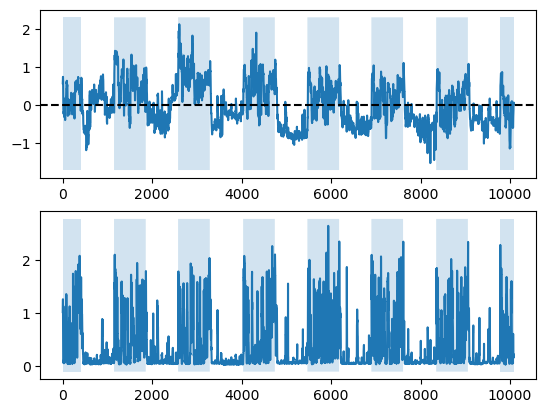

In [30]:
#%matplotlib notebook
fig,ax = plt.subplots(2,1)

temperature = min_data['temp_rt_delta'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[0].plot(temperature)
ax[0].axhline(0,color='k',linestyle='--')
lims = ax[0].get_ylim()
ax[0].fill_between(temperature.index, lims[0], lims[1],where= min_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)

motion = min_data['distance'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[1].plot(motion)
lims = ax[1].get_ylim()
ax[1].fill_between(temperature.index, lims[0], lims[1],where= min_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)


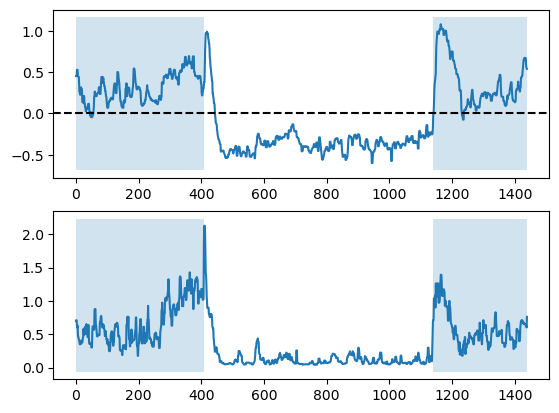

In [31]:
#%matplotlib notebook
fig,ax = plt.subplots(2,1)

day_temperature = day_data['temp_rt_delta'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[0].plot(day_temperature)
ax[0].axhline(0,color='k',linestyle='--')
lims = ax[0].get_ylim()
ax[0].fill_between(day_temperature.index, lims[0], lims[1],where= day_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)

day_motion = day_data['distance'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[1].plot(day_motion)
lims = ax[1].get_ylim()
ax[1].fill_between(day_temperature.index, lims[0], lims[1],where= day_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)


In [1]:
# periodogramma che computa i picchi di oscillazione

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft
from statsmodels.stats.multitest import fdrcorrection


fs = 60
x = temperature

frequencies, power_spectrum = signal.periodogram(x, fs)
frequencies = frequencies
power_spectrum = power_spectrum
period = 1 / frequencies

#sel = period <= 96
#power_spectrum = power_spectrum[sel]
#period = period[sel]
#phase_spectrum = phase_spectrum[sel]

p_values = 1 - power_spectrum  # Convert power values to p-values
rejected, _ = fdrcorrection(p_values)

phase_spectrum = np.angle(fft.fft(x.values))
freq_fft = np.fft.fftfreq(len(x), 1/fs)
freq_pos = np.where(np.isin(freq_fft,frequencies[rejected]))[0]
freq_fft = freq_fft[freq_pos]
phase_spectrum = phase_spectrum[freq_pos]

sorted_peaks = period[rejected]
sorted_amplitudes = power_spectrum[rejected]
sorted_phase = ( (np.mod( phase_spectrum , 2*np.pi) / (2*np.pi))*24 ) *60
peaks_signi = pd.DataFrame({'Period (hours)': sorted_peaks, 'Amplitude': sorted_amplitudes, 'Acrophase': sorted_phase})
plt.figure()
plt.plot(period, power_spectrum)

plt.plot(period[rejected], power_spectrum[rejected], 's')

plt.xlabel('Period (Hours)')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram')


peaks_signi

NameError: name 'temperature' is not defined

Dominant Amplitude: 0.2536910071399247
Dominant Phase: 1.7024714076437606


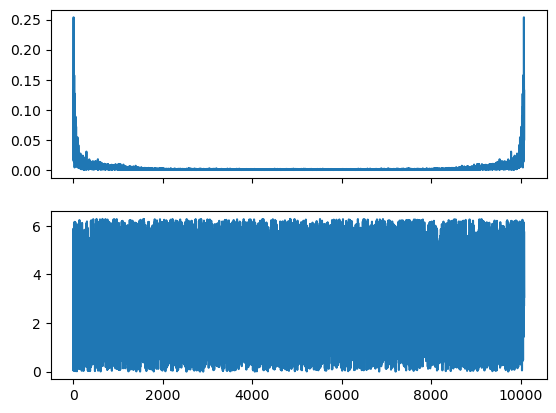

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate or obtain the signal
signal = temperature #amplitude * np.sin(2 * np.pi * frequency * t + phase)
t = len(signal) #np.linspace(0, 1, 1000)  # Time vector
#frequency = 10  # Frequency of the signal
#amplitude = 2  # Amplitude of the signal
#phase = 1  # Phase of the signal

# Calculate the Fourier transform of the signal
fourier_transform = np.fft.fft(signal)
# Find the index of the dominant frequency component
dominant_frequency_index = np.argmax(np.abs(fourier_transform))

dominant_amplitude = 2 * np.abs(fourier_transform[dominant_frequency_index]) / len(signal)
dominant_phase = np.mod( np.angle(fourier_transform[dominant_frequency_index]) + (np.pi/2), 2*np.pi) 


# Print the amplitude and phase of the dominant component
print("Dominant Amplitude:", dominant_amplitude)
print("Dominant Phase:", dominant_phase)

fig,ax = plt.subplots(2,1,sharex=True)
#ax[0].plot(signal)
ax[0].plot(2 * np.abs(fourier_transform) / len(signal))
ax[1].plot( np.mod( np.angle(fourier_transform) + (np.pi/2), 2*np.pi)  )

Dominant Frequency: 0.01
Dominant Magnitude: 499.9176553481658
Dominant Phase: -0.7534816571454643


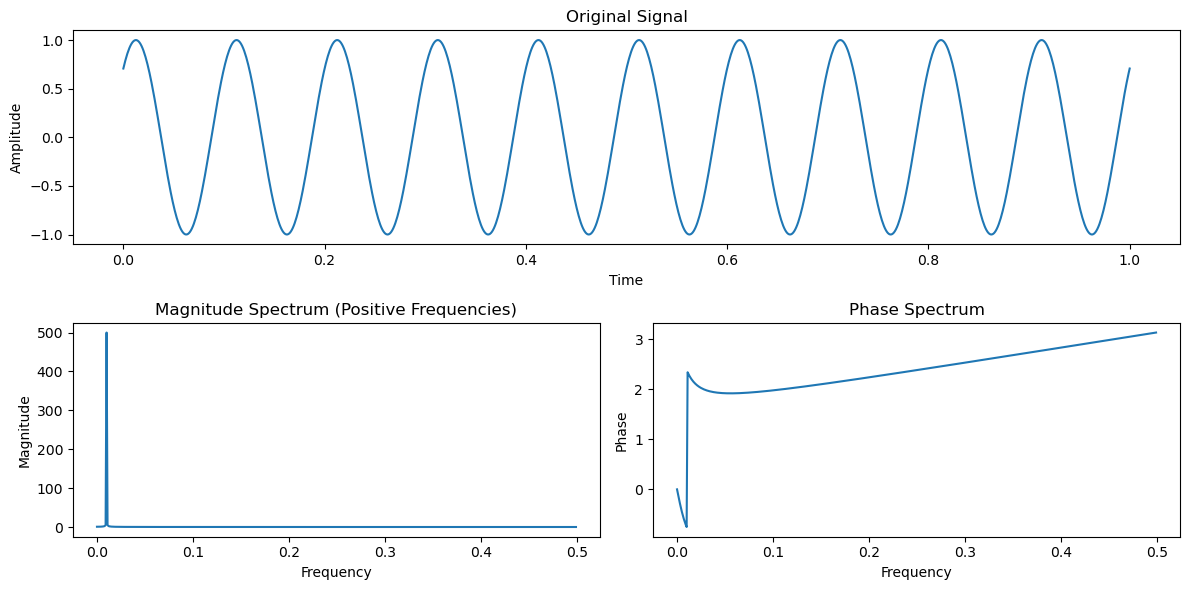

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate or obtain the signal
signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)
t = np.linspace(0, 1, 1000)  # Time vector
frequency = 10  # Frequency of the signal
amplitude = 1  # Amplitude of the signal
phase = np.pi / 4  # Phase of the signal


# Compute the Fourier transform
fft_result = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal))

# Consider only the positive frequencies
positive_indices = np.where(fft_freq >= 0)
positive_freq = fft_freq[positive_indices]
positive_fft = fft_result[positive_indices]

# Compute the magnitude spectrum and phase spectrum
magnitude_spectrum = np.abs(positive_fft)
phase_spectrum = np.angle(positive_fft)

# Find the index of the dominant frequency component
dominant_frequency_index = np.argmax(magnitude_spectrum)
dominant_frequency = positive_freq[dominant_frequency_index]
dominant_magnitude = magnitude_spectrum[dominant_frequency_index]
dominant_phase = phase_spectrum[dominant_frequency_index]

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the original signal
plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original Signal')

# Plot the positive part of the FFT spectrum
plt.subplot(2, 2, 3)
plt.plot(positive_freq, magnitude_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum (Positive Frequencies)')

# Plot the phase spectrum
plt.subplot(2, 2, 4)
plt.plot(positive_freq, phase_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Phase')
plt.title('Phase Spectrum')

# Print the magnitude and phase at the dominant frequency
print("Dominant Frequency:", dominant_frequency)
print("Dominant Magnitude:", dominant_magnitude)
print("Dominant Phase:", dominant_phase)

plt.tight_layout()
plt.show()


C:\Users\pupil\AppData\Local\Temp\ipykernel_16632\3336557874.py:25: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(frequencies, 10 * np.log10(spectrum))


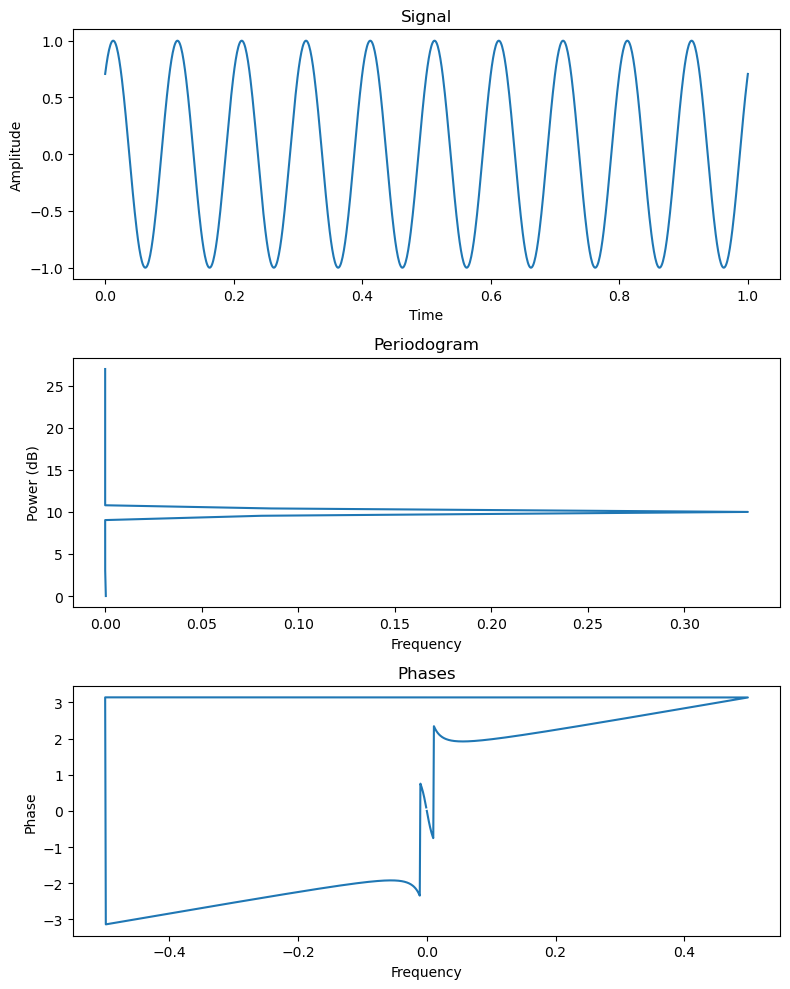

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a signal
t = np.linspace(0, 1, 1000)  # Time vector
frequency = 10  # Frequency of the signal
amplitude = 1  # Amplitude of the signal
phase = np.pi / 4  # Phase of the signal
signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)

# Calculate the periodogram
frequencies, spectrum = plt.psd(signal, NFFT=len(signal), Fs=1000, detrend='linear')
plt.close()  # Close the generated plot

# Calculate the phases
phases = np.angle(np.fft.fft(signal))

# Plot the signal, periodogram, and phases
fig, axs = plt.subplots(3, 1, figsize=(8, 10))
axs[0].plot(t, signal)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Signal')

axs[1].plot(frequencies, 10 * np.log10(spectrum))
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power (dB)')
axs[1].set_title('Periodogram')

axs[2].plot(np.fft.fftfreq(len(signal)), phases)
axs[2].set_xlabel('Frequency')
axs[2].set_ylabel('Phase')
axs[2].set_title('Phases')

plt.tight_layout()
plt.show()


In [12]:
power

NameError: name 'power' is not defined

In [16]:
import numpy as np
import pandas as pd
from scipy.signal import periodogram,fft
from scipy.stats import circmean
from statsmodels.stats.multitest import fdrcorrection

fs = 60  # Sampling frequency (1 minute)
t=temperature.index.values

# Compute the periodogram of the temperature signal
frequencies, power = periodogram(temperature, fs)
spectrum = fft.fft(temperature)
phase_spectrum = np.angle(spectrum)

# Perform FDR correction to adjust p-values
p_values = 1 - power  # Convert power values to p-values
rejected, _ = fdrcorrection(p_values)

# Set the threshold based on the corrected p-values
#threshold = np.max(power[rejected])

# Find frequencies above the threshold
significant_frequencies = frequencies[rejected] #power >= threshold]

# Calculate the period (in hours) of the significant frequencies
periods = 1 / significant_frequencies #* 60  # Convert to hours

# Calculate the acrophase (in hours) of the significant frequencies
acrophases = np.arccos(np.cos(2 * np.pi * significant_frequencies * t.mean())) / (2 * np.pi) * 24

# Calculate the mesor (mean value) of the temperature signal
mesor = np.mean(temperature)

# Create a pandas DataFrame to store the data of the significant components
data = pd.DataFrame({
    'Period (hours)': periods,
    'Acrophase (hours)': acrophases,
})

# Print the mesor and significant components
print("Mesor:", mesor)
print("Significant Components:")
print(data)


ImportError: cannot import name 'fft' from 'scipy.signal' (/home/oldboy/anaconda3/lib/python3.9/site-packages/scipy/signal/__init__.py)

<IPython.core.display.Javascript object>


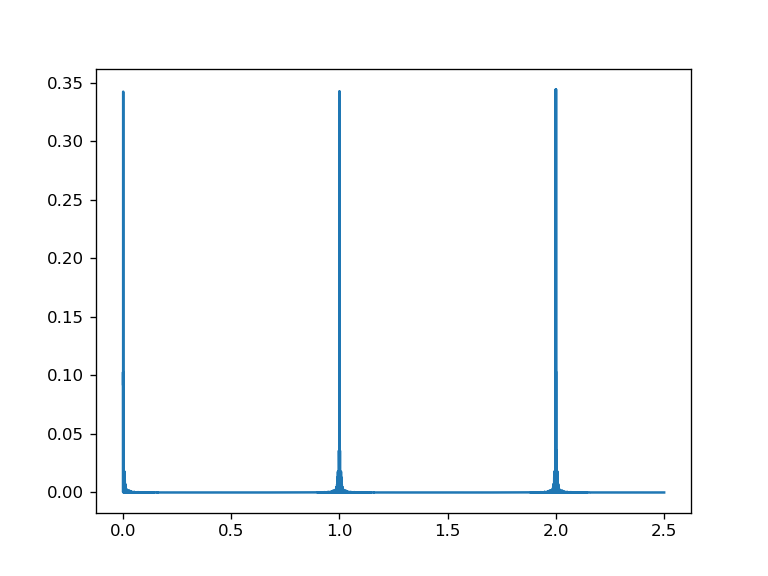

In [78]:
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle

# Generate a sample signal with multiple dominant frequencies
fs = 60
t = temperature.index
x = temperature

# Perform Lomb-Scargle periodogram analysis
frequency, power = LombScargle(t, x).autopower()

# Create a DataFrame to store the periodogram analysis results
df = pd.DataFrame({'Frequency': frequency, 'Power': power})

# Sort the peaks based on power (amplitude)
df = df.sort_values(by='Power', ascending=False)

# Print the DataFrame
fig,ax = plt.subplots()
plt.plot(frequency,power)

In [36]:
frequencies

array([  0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,  33.75 ,
        39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,  73.125,
        78.75 ,  84.375,  90.   ,  95.625, 101.25 , 106.875, 112.5  ,
       118.125, 123.75 , 129.375, 135.   , 140.625, 146.25 , 151.875,
       157.5  , 163.125, 168.75 , 174.375, 180.   , 185.625, 191.25 ,
       196.875, 202.5  , 208.125, 213.75 , 219.375, 225.   , 230.625,
       236.25 , 241.875, 247.5  , 253.125, 258.75 , 264.375, 270.   ,
       275.625, 281.25 , 286.875, 292.5  , 298.125, 303.75 , 309.375,
       315.   , 320.625, 326.25 , 331.875, 337.5  , 343.125, 348.75 ,
       354.375, 360.   , 365.625, 371.25 , 376.875, 382.5  , 388.125,
       393.75 , 399.375, 405.   , 410.625, 416.25 , 421.875, 427.5  ,
       433.125, 438.75 , 444.375, 450.   , 455.625, 461.25 , 466.875,
       472.5  , 478.125, 483.75 , 489.375, 495.   , 500.625, 506.25 ,
       511.875, 517.5  , 523.125, 528.75 , 534.375, 540.   , 545.625,
       551.25 , 556.

In [12]:

def parsedate(date):
    try:
        return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').day
    except:
        return np.nan

#for i,row in df.iterrows():
#     print( int( row['Date'].split(' ')[0].split('-')[-1]) ) 
df['Day'] = df['Date'].apply(lambda x: int(x.split(' ')[0].split('-')[-1]), meta=('int') )
df['Day_rel'] = df['Day'] - df['Day'].unique().compute().min()
#df['Day_rel'] = df['Day']-df['Day'].loc[0]
df.head()

C:\Users\pupil\anaconda3\lib\site-packages\dask\dataframe\core.py:6169: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


,index_old,ID,Date,timeStamp,hour,minute,RT,isDay,temp_avg,temp_med,temp_max,centroid_x,centroid_y,distance,Day
0,0,1.0,2023-05-19 12:00:00,2027.809737,12.0,720.0,20.486520,1.0,25.495870,25.495870,28.647199,76.937322,45.588590,NaN,19
1,1,2.0,2023-05-19 12:00:00,2028.015251,12.0,720.0,20.493791,1.0,25.325776,25.325776,28.440092,78.679304,45.558714,1.742238,19
2,2,3.0,2023-05-19 12:00:00,2028.127524,12.0,720.0,20.500572,1.0,25.444307,25.444307,28.552307,78.295316,45.377368,0.424657,19
3,3,4.0,2023-05-19 12:00:00,2028.245897,12.0,720.0,20.496732,1.0,25.381336,25.381336,28.466030,77.857371,44.580024,0.909700,19
4,4,5.0,2023-05-19 12:00:00,2028.355840,12.0,720.0,20.492320,1.0,25.401985,25.401985,28.640290,78.615925,44.828350,0.798167,19


In [22]:
df['Day_rel'].unique().compute()

0    0
1    1
2    2
3    3
Name: Day_rel, dtype: int64

In [17]:

#df['mot_dist'] = np.sqrt((df['centroid_x'] - df['centroid_x'].shift(1))**2 + (df['centroid_y'] - df['centroid_y'].shift(1))**2)
#df['mot_dist'] = df['mot_dist'].fillna(0)



avg_min
#avg_min

,ID,timeStamp,hour,RT,isDay,temp_avg,temp_med,temp_max,centroid_x,centroid_y,distance
0,1.336434e+06,155847.136659,6.0,20.928277,0.000000,24.925562,24.925562,27.409255,45.632617,75.221100,0.663761
1,1.339281e+06,156172.399806,6.0,20.909420,0.597041,25.012292,25.012292,27.473522,44.624407,77.711148,0.630961
2,1.339671e+06,156218.470433,6.0,20.905223,1.000000,24.838781,24.838781,27.161659,48.362016,86.507362,0.468760
3,1.343349e+06,156640.463707,6.0,20.903320,1.000000,24.810668,24.810668,27.235981,51.050258,91.076157,0.222031
4,1.343131e+06,156616.988766,6.0,20.898115,1.000000,24.820788,24.820788,27.236991,48.647908,89.847007,0.322865
...,...,...,...,...,...,...,...,...,...,...,...
1436,1.345731e+06,156909.814315,6.0,20.934016,0.000000,24.817289,24.817289,27.277771,47.785162,85.979589,0.530997
1437,1.341345e+06,156406.007745,6.0,20.939502,0.000000,24.786358,24.786358,27.323865,44.175829,81.319092,0.785412
1438,1.336503e+06,155852.942435,6.0,20.933071,0.000000,24.851544,24.851544,27.305942,46.083188,80.210620,0.840904
1439,1.334818e+06,155660.904451,6.0,20.906522,0.000000,24.913386,24.913386,27.426630,43.668838,81.474248,0.728567


<IPython.core.display.Javascript object>


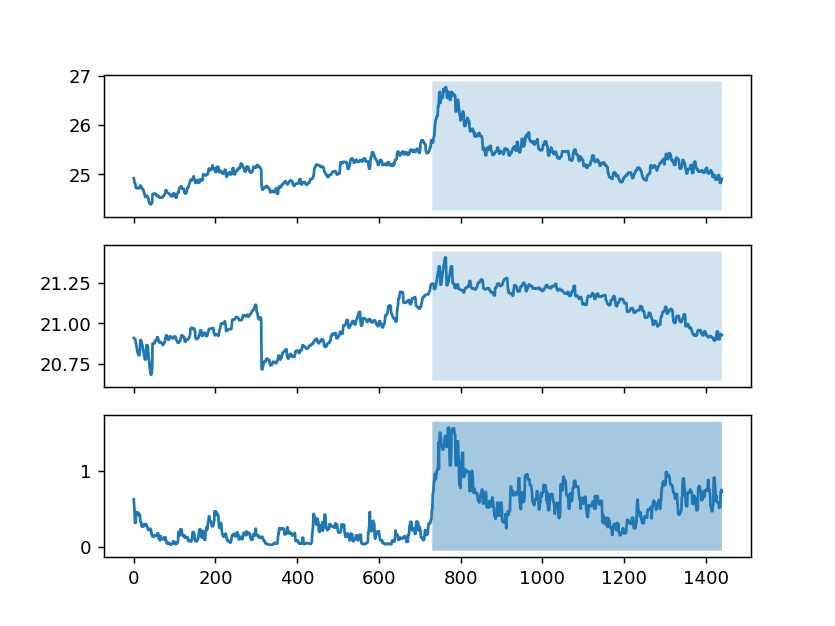

In [18]:

%matplotlib notebook

fig,ax = plt.subplots(3,1,sharex=True)

avg_min[['temp_avg','RT','distance']] = avg_min[['temp_avg','RT','distance']].rolling(5,center=True,min_periods=1).median()
ax[0].plot(avg_min.index,avg_min['temp_avg'])
ylim = ax[0].get_ylim()
ax[0].fill_between(avg_min.index,y1=ylim[0],y2=ylim[1], where=avg_min['isDay']<0.5,alpha=.2)

ax[1].plot(avg_min.index,avg_min['RT'])
ylim = ax[1].get_ylim()
ax[1].fill_between(avg_min.index,y1=ylim[0],y2=ylim[1], where=avg_min['isDay']<0.5,alpha=.2)

ax[2].plot(avg_min.index,avg_min['distance'])
ylim = ax[2].get_ylim()
ax[2].fill_between(avg_min.index,y1=ylim[0],y2=ylim[1], where=avg_min['isDay']<0.5,alpha=.4)


In [23]:


pth = Path(r'C:\Users\pupil\Downloads\thermal_behaviour_72_h')


def readTher(fnames):
    df = dd.read_csv((fnames/'data.csv').as_posix(), sep=';', skiprows=1, 
                     assume_missing=True)  
    df['distance'] = df.map_partitions(euclid) # da cambiare
    df = df.reset_index().rename(columns={'index':'index_old'})

    avg_min = df.groupby(['ID']).mean()
    avg_min = df.groupby(['minute']).mean()

    avg_min = avg_min.compute()
    avg_min = pd.concat([avg_min.loc[407:],avg_min.loc[:407]]).reset_index(drop=True)
    return avg_min

fnames = pth / '20230519_113859-ROI_*-WT_*'
wt = readTher(fnames)
fnames = pth / '20230519_113859-ROI_*-KO_*'
ko = readTher(fnames)


<IPython.core.display.Javascript object>


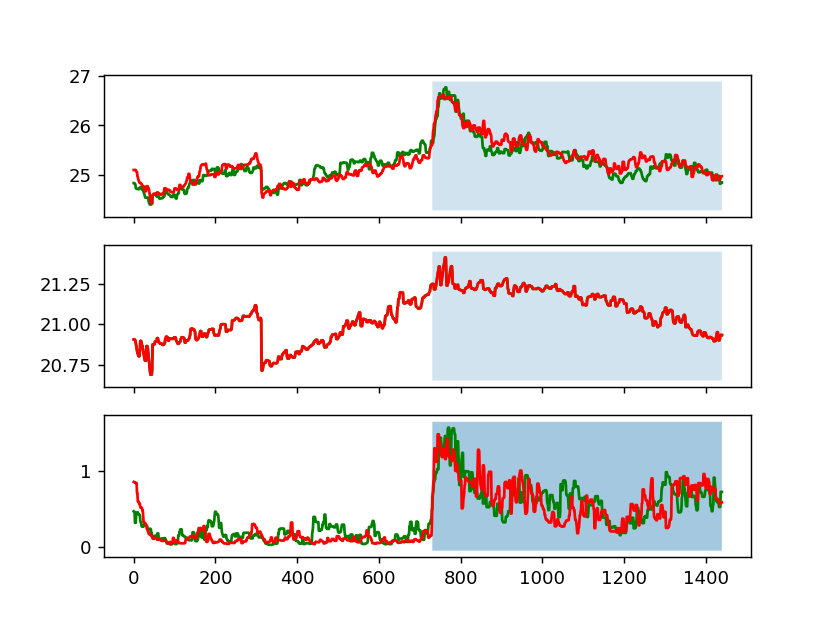

In [29]:
%matplotlib notebook

fig,ax = plt.subplots(3,1,sharex=True)

wt[['temp_avg','RT','distance']] = wt[['temp_avg','RT','distance']].rolling(5,center=True,min_periods=1).median()
ko[['temp_avg','RT','distance']] = ko[['temp_avg','RT','distance']].rolling(5,center=True,min_periods=1).median()

ax[0].plot(wt.index,wt['temp_avg'],'g')
ax[0].plot(ko.index,ko['temp_avg'],'r')
ylim = ax[0].get_ylim()
ax[0].fill_between(wt.index,y1=ylim[0],y2=ylim[1], where=wt['isDay']<0.5,alpha=.2)

ax[1].plot(wt.index,wt['RT'],'g')
ax[1].plot(ko.index,ko['RT'],'r')
ylim = ax[1].get_ylim()
ax[1].fill_between(wt.index,y1=ylim[0],y2=ylim[1], where=wt['isDay']<0.5,alpha=.2)

ax[2].plot(wt.index,wt['distance'],'g')
ax[2].plot(ko.index,ko['distance'],'r')
ylim = ax[2].get_ylim()
ax[2].fill_between(wt.index,y1=ylim[0],y2=ylim[1], where=wt['isDay']<0.5,alpha=.4)

